# Using a library for topic modeling with Latent Dirichlet Allocation

This self-study notebook shows how to use a machine learning library to train a Latent Dirichlet Allocation model for a small corpus and then inspect what the model has learned. As you recall from the description of this type of model, there are two things we will get from an LDA model:
- a set of **topics**: groups of words relating to a common topic;
- for a given document: a **topic distribution** that shows how we analyze this document in terms of topics.

**PLEASE NOTE** that what you will do in Assignment 2 is different. In the assignment, your goal is to implement the learning algorithm on your own. In this notebook, we are just going to use a library.

There is also an important technical difference: in the assignment, you are going to use an [Gibbs sampling](https://en.wikipedia.org/wiki/Gibbs_sampling) to train the model, while the library uses a completely different approach called [variational inference](https://en.wikipedia.org/wiki/Variational_Bayesian_methods). To make a long story very short, the key differences between these two approaches to training Bayesian models are:
- **MCMC/Gibbs sampling** is based on repeated sampling. It generally gives higher-quality estimates but is more time-consuming.
- **Variational inference** optimizes a quantity that approximates the model likelihood. It is typically faster but the estimates may be less reliable.

### Libraries that include an LDA implementation

You can find LDA implementation in many libraries. Some of the most well-known are:

- [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html): uses variational inference.
- [gensim](https://radimrehurek.com/gensim/): also variational inference.
- [mallet](http://mallet.cs.umass.edu/topics.php): uses Gibbs sampling.

In this notebook, we are going to use the implementation from scikit-learn, for the simple reason that most of you probably already have this library installed. (This library as well as gensim are also pre-installed on Colab.) Its implementation uses training algorithm described in [this paper](https://papers.nips.cc/paper/2010/hash/71f6278d140af599e06ad9bf1ba03cb0-Abstract.html).

**Acknowledgement**: this notebook is based on [the following example](https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html) from the scikit-learn documentation.

### Reading the documents

The zip file [here](http://www.cse.chalmers.se/~richajo/dat450/data/dredze_amazon_reviews.zip) contains a processed version of a corpus originally described in the paper [*Biographies, Bollywood, Boom-boxes and Blenders: Domain Adaptation for Sentiment Classification*](https://aclanthology.org/P07-1056.pdf) by Blitzer et al. (2007). (You may have encountered the same dataset in other courses Richard taught...)

The corpus consists of about 12,000 product reviews scraped from Amazon. The reviews are selected from six product categories (books, cameras, DVDs, music, health and software). The reviews are also tagged with sentiment polarity values (positive or negative). Each line in the file consists of one review. For instance, in the following line
```
music neg 544.txt i was misled and thought i was buying the entire cd and it contains one song 
```
we have a music review with negative sentiment polarity. The third column is an ID we won't consider, and the rest of the line contains the words in the review text. The text has already been tokenized and lowercased.

We first read the corpus. For the notebook, we are actually just going to use the text, but we also store the product type labels which may become useful when we look at the results.

In [1]:
!wget http://www.cse.chalmers.se/~richajo/dat450/data/dredze_amazon_reviews.zip
!unzip dredze_amazon_reviews.zip

--2021-11-08 10:52:39--  http://www.cse.chalmers.se/~richajo/dat450/data/dredze_amazon_reviews.zip
Resolving www.cse.chalmers.se (www.cse.chalmers.se)... 129.16.221.33
Connecting to www.cse.chalmers.se (www.cse.chalmers.se)|129.16.221.33|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3480597 (3,3M) [application/zip]
Saving to: ‘dredze_amazon_reviews.zip’

dredze_amazon_revie 100%[===================>]   3,32M   119KB/s    in 24s     

2021-11-08 10:53:04 (140 KB/s) - ‘dredze_amazon_reviews.zip’ saved [3480597/3480597]

Archive:  dredze_amazon_reviews.zip
  inflating: dredze_amazon_reviews.txt  


In [2]:
docs = []
prod_lbls = []
sent_lbls = []

with open('dredze_amazon_reviews.txt') as f:
    for l in f:
        prod, sent, _, doc = l.strip().split(maxsplit=3)
        docs.append(doc)
        prod_lbls.append(prod)
        sent_lbls.append(sent)

To take one example, here is a book review with positive polarity:

In [3]:
doc_index = 3
docs[doc_index], prod_lbls[doc_index], sent_lbls[doc_index]

('anything you purchase in the left behind series is an excellent read . these books are great and very close to the bible . i have the entire set . amazon is a great shopping site and they ship fast . i would recommend these to any christian wanting to know about what to expect during the return of christ ! they are fiction but still makes a good point',
 'books',
 'pos')

### Preprocessing documents

We convert the documents into a [document-term matrix](https://en.wikipedia.org/wiki/Document-term_matrix) (that is: a matrix contain word frequencies for each document) by applying the [`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) from scikit-learn. We exclude [stop words](https://en.wikipedia.org/wiki/Stop_word): general grammatical words that we think will not be useful when finding the topics. (It is common practice when using LDA to remove the stop words, but there are [some arguments](https://aclanthology.org/E17-2069/) about whether this is useful or not.) We include the 1,000 most frequent words in the matrix.

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

tf_vectorizer = CountVectorizer(
    max_features=1000, stop_words="english"
)
doc_matrix = tf_vectorizer.fit_transform(docs)

This matrix has 11,914 rows and 1,000 columns; make sure you understand why.

In [10]:
doc_matrix.shape

(11914, 1000)

### Training an LDA model

When we have the matrix representing the word frequencies in each document, it is a simple matter of applying scikit-learn's LDA implementation. Here is an example of how this can be done. The model should train in a few seconds.

In [11]:
from sklearn.decomposition import LatentDirichletAllocation
from time import time

print("Training the LDA model...")
lda = LatentDirichletAllocation(
    n_components=10,           # number of topics
    learning_method="online",  # faster training by using the "online" algorithm
    max_iter=5,                # number of epochs
    random_state=0,            # random seed for reproducibility
    n_jobs=-1,                 # uses all available CPU cores
    verbose=1                  # shows some output during training
)
t0 = time()
lda.fit(doc_matrix)
print(f"Trained in {time()-t0:.3f} seconds.")

Training the LDA model...
iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5
Trained in 10.189 seconds.


As you see, there are some different hyperparameters we can play with.

- `n_components`: Probably, the most interesting hyperparameter is the number of topics. In practice, the rule of thumb is that the more fine-grained model we want to train, the more training data we need. So it's probably a good idea to use a rather small set of topics for this small set of documents.
- `learning_method`: When we use the `online` algorithm, we apply the method described in [this paper](https://papers.nips.cc/paper/2010/hash/71f6278d140af599e06ad9bf1ba03cb0-Abstract.html). The key idea is similar to stochastic gradient descent: we update the model in small increments, after processing a small number of documents. The alternative is `batch`: in this case, we update the model after processing all documents. `batch` might be mathematically somewhat more stable but `online` typically requires fewer iterations.
- `max_iter`: the maximal number of iterations used in the training algorithm. 
- `random_state`: the random seed. If you change this, your topics will probably be different.

### Showing the learned topics

Now, let's see what the model has learned. We define a function that will let us visualize the topics. For each topic, it will draw a bar for the subset of words with the highest occurrence probabilities. (This code has been adapted from [this example](https://papers.nips.cc/paper/2010/hash/71f6278d140af599e06ad9bf1ba03cb0-Abstract.html).)

The function needs a trained LDA model, a list of words in the vocabulary, and the number of words to show for each topic.

In [12]:
from math import ceil
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg' 
plt.style.use('seaborn')

def plot_top_words(model, feature_names, n_top_words):
    n_topics = len(model.components_)
    n_cols = 5
    n_rows = ceil(n_topics/n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 5), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 14})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=10)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

Here is the result of applying the visualization function. We get the vocabulary from the `CountVectorizer` we used to build the word count matrix.

**Reflection**: how do the topics relate to the content of our corpus? Can you interpret the topics? Do you think we have found everything there is to find?

/home/jona/miniconda3/envs/NLP/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


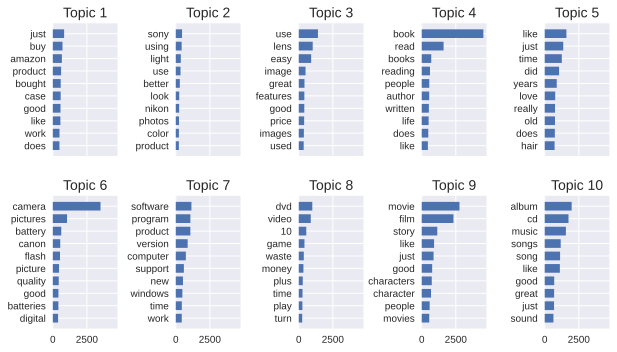

In [13]:
plot_top_words(lda, tf_vectorizer.get_feature_names(), 10)

We also define a function that simply prints the top words in each topic as text. This might be more useful than the visualization if you are working with an LDA model with a large number of topics.

In [14]:
def print_top_words(model, feature_names, n_top_words):
    for i, topic in enumerate(model.components_, 1):
        top_words = sorted(zip(topic, feature_names), reverse=True)[:n_top_words]
        print(f'{i:2d}', ' '.join(w for _, w in top_words))

### Predicting the topics for a new document

If you have a new document, you can use the trained model to estimate the topic proportions for it. This is done in two steps: first, the document is converted into a matrix, and then the inference is carried out.

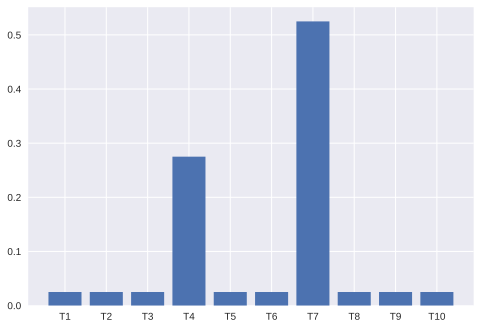

In [15]:
test_doc = 'this book describes windows software'
#test_doc = 'i love my new mac , it is wonderful !'
#test_doc = 'i hate my new razor , it is horrible !'

# build a word frequency matrix for this document
test_doc_encoded = tf_vectorizer.transform([test_doc])

# apply the LDA model to get a topic distribution for this document
# the result is a vector of predicted topic proportions
test_doc_topics = lda.transform(test_doc_encoded)[0]

# now, let's draw a bar plot
names = [f'T{i+1}' for i in range(len(test_doc_topics))]
plt.bar(names, test_doc_topics);

The result shows predicted topic distribution. In most cases, there will be one or more dominant topics, and small probabilities for the rest of the topics.

For instance, for the document `this book describes Windows software`, we will typically get a result that this document is a mix of a book-related topic and a software-related topic. (Compare to the topic list you got above.)

### Reflection

- Do you see a problem from a **scientific point of view** with the approach you just used? Is it a good approach scientifically to let the model output something and then "read the tea leaves" and try to come up with a reason for why you got this result?
- What do you think of the effect of **randomness** on the results? (That is, what happens if you adjust `random_state`.)
- How do you think we should **evaluate** a topic model? What does it mean for topics to be good, or the topic assignment for a document to be good? As for all unsupervised learning, topic modeling evaluation is a tricky subject; [this paper](https://papers.nips.cc/paper/2009/hash/f92586a25bb3145facd64ab20fd554ff-Abstract.html) may be a good starting point.

### Optional example: topic modeling in software engineering

[This file](http://www.cse.chalmers.se/~richajo/dat450/data/mozilla_bugs.zip) contains a set of 25,000 bug reports from the Mozilla projects (involving e.g. the Firefox browser and Thunderbird email client etc). These bug reports were collected as part of a research project by [Leif Jonsson](https://github.com/lejon) of Linköping University and Ericsson. See [his paper](https://ieeexplore.ieee.org/document/7589822) for more details about the data.

Train an LDA model with a suitable number of topics and reflect about the results. What uses do you see for LDA models in software engineering?